<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/02_Detection_of_Talent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌟 🏆  Detection Of Talent Using ML 🤖 🚀

### - Antonio Guerrero

In [66]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch

# Libraries for Machine Learning 🤖
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [67]:
# Lets get drive data (if u want to replicate use your directory)  🔵🔴🟡🟢

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'


df = pd.read_csv(path + 'Full_Dataset_2021-2025.csv')
df_players = pd.read_csv(path + 'df_players_info_full.csv')
df_metrics = pd.read_csv(path + 'df_advanced_metrics.csv')

# Lets get the array of the match ids (Just in case)

#Credentials for Statsbomb from ITAM (Again, thanks ITAM 🟢)
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Info about our dataset

df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   playerId                     1234 non-null   int64  
 1   playerName                   1234 non-null   object 
 2   minutesPlayed                1234 non-null   float64
 3   gk_GoalsPrevented_p90        61 non-null     float64
 4   gk_AvgSaveDifficulty         61 non-null     float64
 5   def_OBV_p90                  1234 non-null   float64
 6   def_OppHalfRecoveries_p90    1234 non-null   float64
 7   def_DuelWinRate              1234 non-null   float64
 8   flow_WeightedDegree_p90      1045 non-null   float64
 9   flow_Betweenness             1045 non-null   float64
 10  flow_Eigenvector             1045 non-null   float64
 11  off_xGChain_p90              1234 non-null   float64
 12  off_FinishingDifferential    1234 non-null   float64
 13  off_OpportunityCre

In [69]:
# What we got

df_metrics.describe()

,playerId,minutesPlayed,gk_GoalsPrevented_p90,gk_AvgSaveDifficulty,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90,X,Y
count,1234.000000,1234.000000,61.000000,61.000000,1234.000000,1234.000000,1234.000000,1045.000000,1045.000000,1045.000000,1234.000000,1234.000000,1234.000000,1234.000000,1045.000000,1045.000000
mean,138072.949757,2277.470827,-0.121397,0.305709,0.032829,1.669799,17.837638,63.867360,0.097109,0.259505,1.482270,0.059291,0.159185,0.056511,52.461947,50.326047
std,153435.464368,3054.917074,0.256695,0.085046,0.061020,2.409856,16.624833,23.766840,0.050802,0.075479,4.082049,1.649964,0.218163,0.311158,15.420899,18.472131
min,3058.000000,0.000000,-1.023948,0.093842,-0.855639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.735431,0.000000,-6.710254,7.263924,1.437500
25%,28517.500000,53.500000,-0.144340,0.268205,0.000000,0.000000,0.000000,50.000000,0.072459,0.214469,0.593689,-0.373000,0.000312,0.000000,45.069777,42.083162
50%,43548.500000,855.000000,-0.068319,0.294858,0.029358,1.583242,19.011761,62.077295,0.088559,0.269350,0.812776,0.000000,0.086952,0.069197,55.696342,50.628806
75%,273518.750000,3403.750000,-0.002832,0.322907,0.054221,2.432152,27.774365,75.421166,0.115297,0.308844,1.252213,0.045316,0.257155,0.145702,63.949133,60.010870
max,474814.000000,13814.000000,0.348216,0.719212,0.807319,45.000000,100.000000,300.000000,0.666667,0.519277,70.515000,14.809140,3.372735,4.503375,96.666667,93.500000


### Lets clean and filter players 🧹

In [70]:
# 🎯 Set a minimum minutes played threshold to ensure statistical reliability (We select at least 10 games = 900 minutes)
MIN_MINUTES = 900

# ✂️ Filter the DataFrame to keep only players who meet the threshold.
df_filtered = df_metrics[df_metrics['minutesPlayed'] >= MIN_MINUTES].copy()

print(f"Players before minutes filter: {len(df_metrics)}")
print(f"Players after minutes filter: {len(df_filtered)}")

Players before minutes filter: 1234
Players after minutes filter: 607


In [71]:
# 🧤 Goalkeepers are identified by having non-null values in GK-specific columns.
df_gk = df_filtered[df_filtered['gk_GoalsPrevented_p90'].notna()].copy()

# 🏃‍♂️ Outfield players are everyone else.
df_outfield = df_filtered[df_filtered['gk_GoalsPrevented_p90'].isna()].copy()

print(f"Goalkeepers to analyze: {len(df_gk)}")
print(f"Outfield players to analyze: {len(df_outfield)}")

Goalkeepers to analyze: 48
Outfield players to analyze: 559


In [72]:
# 1. 🗑️ Drop irrelevant columns for outfield analysis (the goalkeeper metrics).
df_outfield = df_outfield.drop(columns=['gk_GoalsPrevented_p90', 'gk_AvgSaveDifficulty'])

# 2. ✨ Handle null values.
# Nulls in 'flow_' and 'X'/'Y' mean the player
# didn't register valid passes. For clustering, we need complete data,
# so we will drop these rows.
# So we dont use player who touched the ball or participated in team cohesion
df_outfield_clean = df_outfield.dropna().copy()

print(f"Outfield players before cleaning nulls: {len(df_outfield)}")
print(f"Outfield players after cleaning nulls: {len(df_outfield_clean)}")

Outfield players before cleaning nulls: 559
Outfield players after cleaning nulls: 559


In [73]:
# 💾 Store player IDs for later use (e.g., labeling clusters).
player_ids = df_outfield_clean['playerId']

# 📊 Select only the feature columns for the machine learning model.
metrics_columns = [
    'def_OBV_p90', 'def_OppHalfRecoveries_p90', 'def_DuelWinRate',
    'flow_WeightedDegree_p90', 'flow_Betweenness', 'flow_Eigenvector',
    'off_xGChain_p90', 'off_FinishingDifferential', 'off_OpportunityCreation_p90',
    'off_OBV_p90', 'X', 'Y'
]

X = df_outfield_clean[metrics_columns]

# ⚖️ Initialize the StandardScaler and transform the data.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ X_scaled is now a NumPy array, ready for our ML models
print("Shape of the scaled feature matrix:", X_scaled.shape)

Shape of the scaled feature matrix: (559, 12)


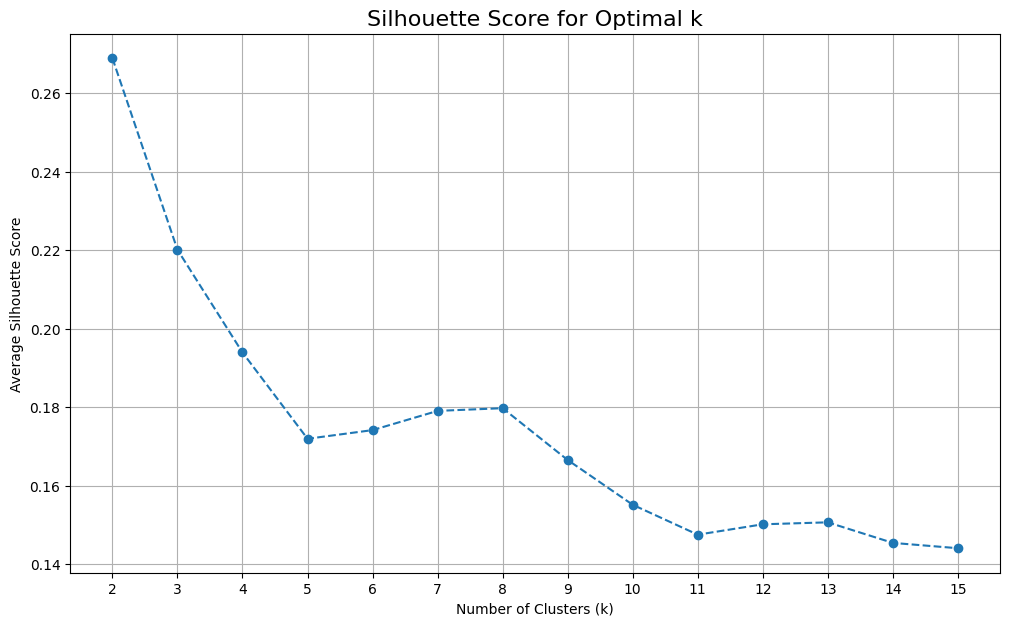

In [74]:
# 📏 silhouette_scores will store the average silhouette score for each k
silhouette_scores = []
k_range = range(2, 16) # 🔢 For silhouette, k must be >= 2

# 🔄 Loop through each number of clusters
for k in k_range:
    # Initialize and fit the K-Means model
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Calculate the silhouette score and append it to our list
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# 🎨 Plot the Silhouette Scores graph
plt.figure(figsize=(12, 7))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [75]:
# --- PHASE 3: CLUSTERING ---

# 🎯 7. Define our chosen number of clusters
OPTIMAL_K = 7

# 🧠 8. Initialize and train the K-Means model
kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_scaled)


# --- FINAL DATAFRAME ASSEMBLY ---

# 🚀 9. Create our final analysis dataframe. It already has the names!
df_analysis = df_outfield_clean.copy()

# 🏷️ 10. Assign the new cluster labels to each player
df_analysis['cluster'] = kmeans.labels_


# ==============================================================================
# ✅ WORKFLOW COMPLETE
# ==============================================================================

print("✅ Workflow Complete! Player archetypes have been assigned.")

# 📝 Display a sample of the final dataframe using the 'playerName' column that was already there.
print("\nSample of players with their assigned clusters:")
display(df_analysis[['playerName', 'minutesPlayed', 'cluster']].head())

# 👀 Display the number of players in each cluster
print("\nPlayer count per cluster:")
display(df_analysis['cluster'].value_counts().sort_index())

✅ Workflow Complete! Player archetypes have been assigned.

Sample of players with their assigned clusters:


,playerName,minutesPlayed,cluster
0,Javier Güemez López,12245.0,0
4,Unai Bilbao Arteta,10515.0,3
5,Juan David Castro Ruiz,1863.0,6
6,Ricardo Chávez Soto,12372.0,1
8,Jair Alberto Díaz Vázquez,7573.0,4



Player count per cluster:


,count
cluster,
0,74
1,80
2,34
3,107
4,66
5,89
6,109


In [76]:
# 📊 Group by cluster and calculate the mean for all metrics.
cluster_profiles = df_analysis.groupby('cluster')[metrics_columns].mean()

# 🔄 Transposing the table (.T) makes it easier to read and compare.
print("Cluster Profiles (Average Metrics):")
display(cluster_profiles.T)

Cluster Profiles (Average Metrics):


cluster,0,1,2,3,4,5,6
def_OBV_p90,0.050127,0.052909,0.031415,0.073447,0.051430,0.025793,0.032379
def_OppHalfRecoveries_p90,2.543467,1.783472,2.775761,0.630252,1.499516,1.937020,2.775073
def_DuelWinRate,29.545961,27.301556,25.981850,24.485860,26.754871,10.187507,22.909238
flow_WeightedDegree_p90,86.188224,66.854623,78.111404,65.882257,66.132427,48.252330,64.472669
flow_Betweenness,0.066126,0.082961,0.081584,0.087905,0.086310,0.134548,0.094079
flow_Eigenvector,0.346383,0.291827,0.305955,0.288690,0.286437,0.192102,0.269222
off_xGChain_p90,0.731241,0.825164,0.761499,0.652631,0.791593,0.961887,1.045419
off_FinishingDifferential,-0.072566,-0.284384,5.277184,-0.357206,0.226564,0.117647,-0.290060
off_OpportunityCreation_p90,0.165358,0.099741,0.366152,0.062814,0.121503,0.430664,0.288646
off_OBV_p90,0.118267,0.131175,0.186515,0.073306,0.160289,-0.026837,0.125355


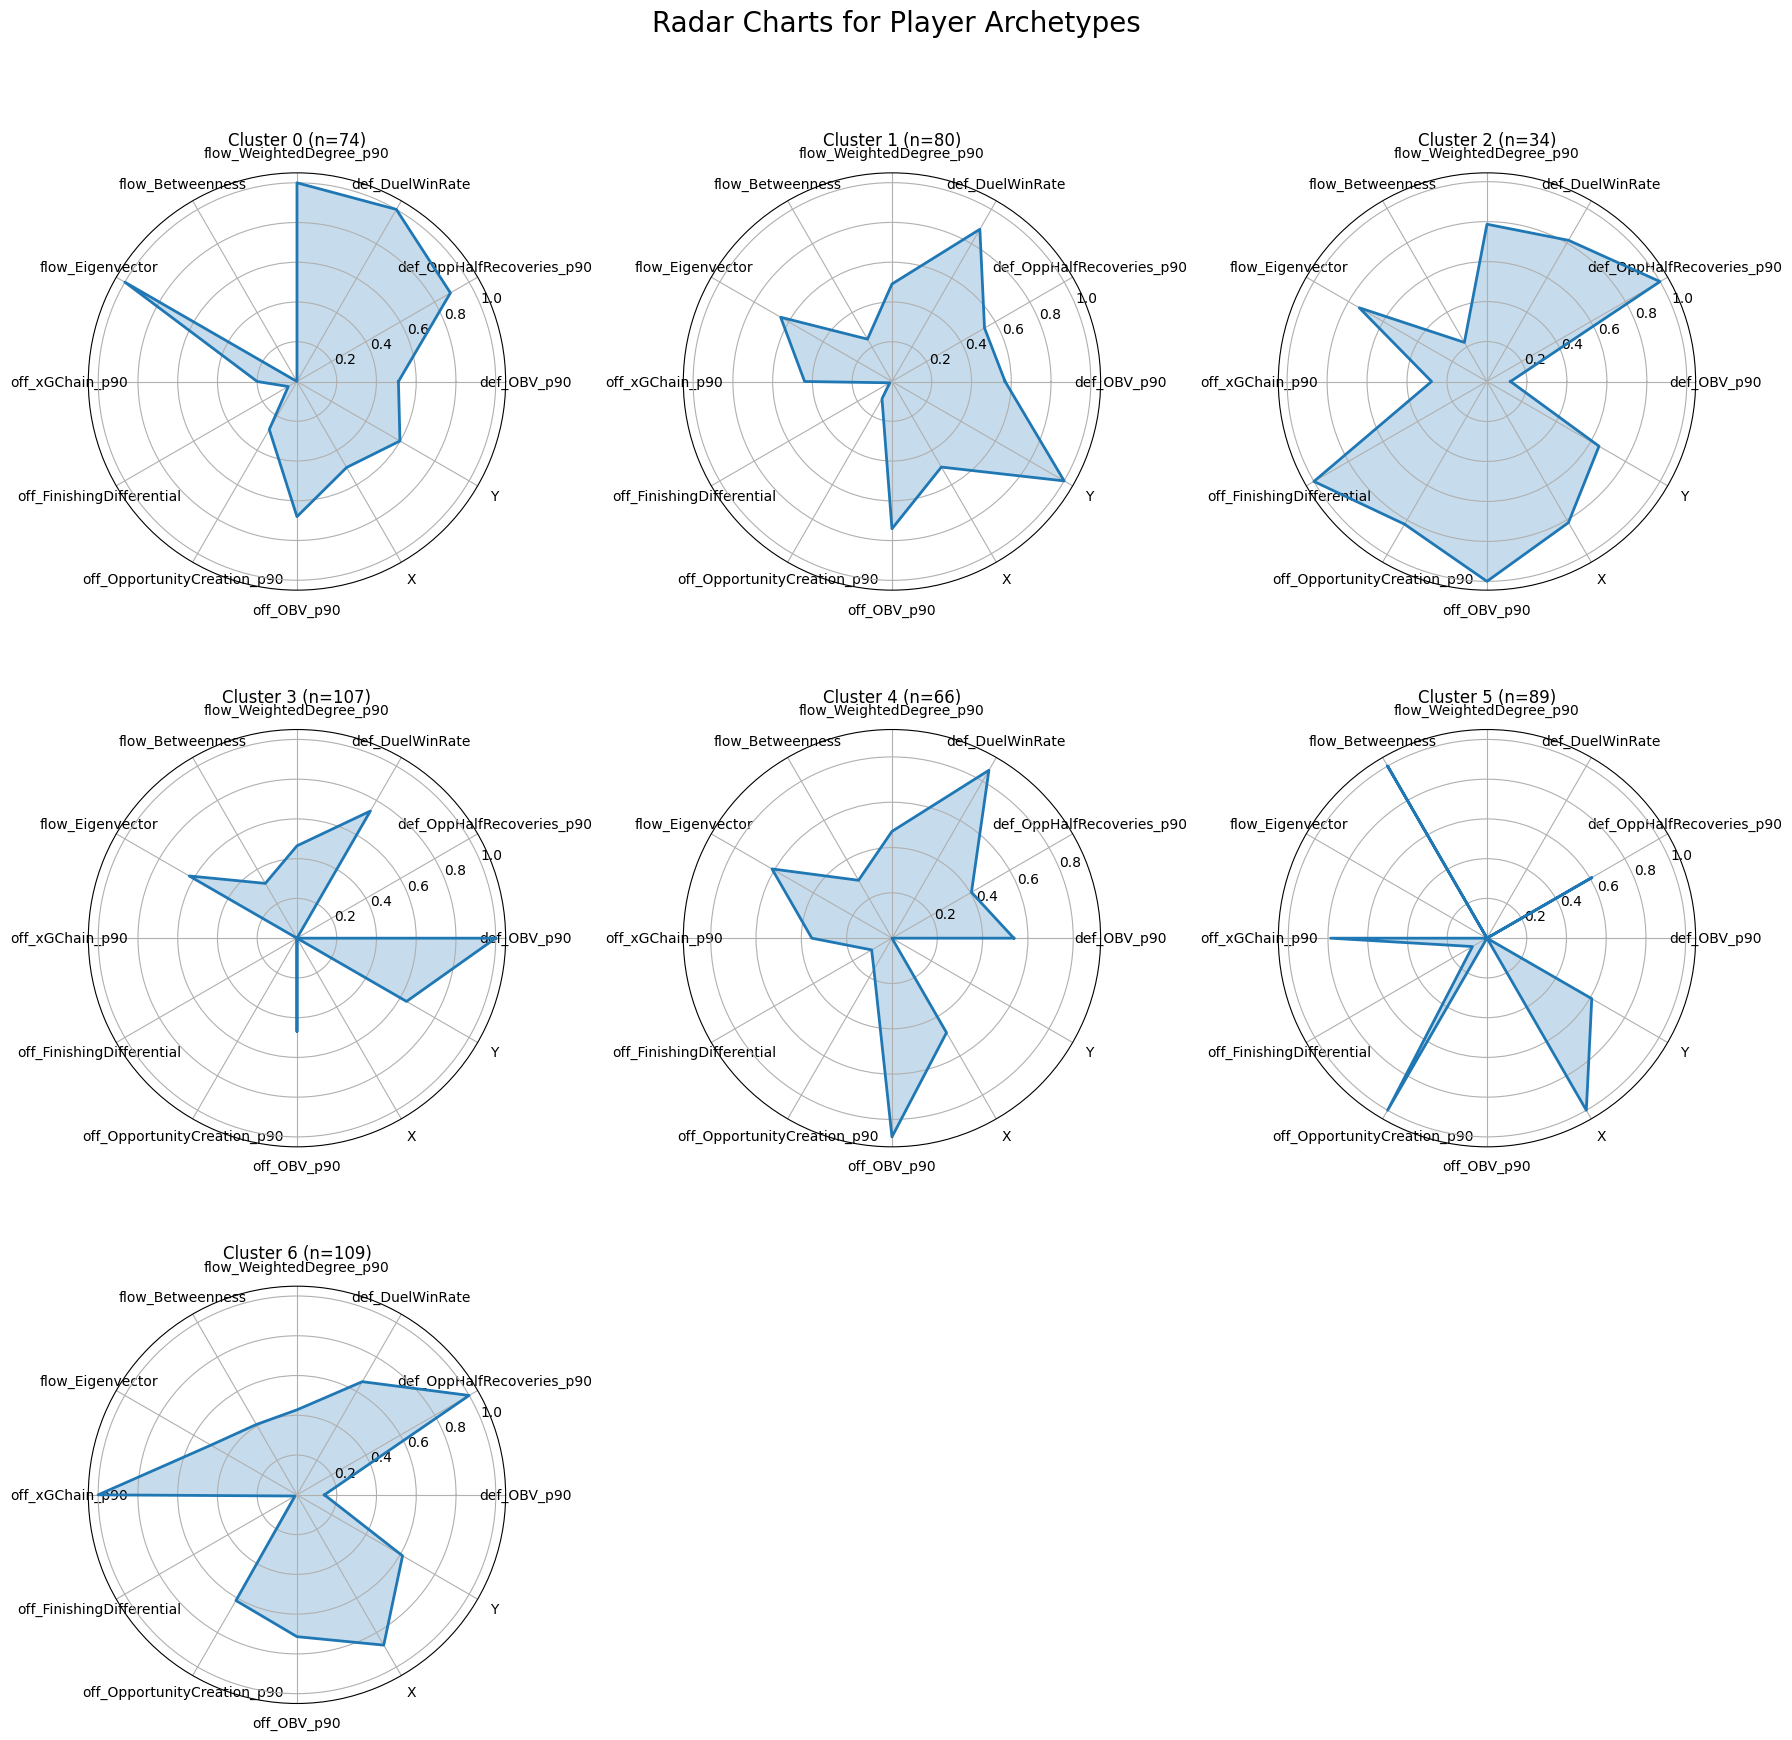

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ⚖️ Scale the profiles to a 0-1 range for a fair visual comparison.
scaler_viz = MinMaxScaler()
profiles_scaled = scaler_viz.fit_transform(cluster_profiles)
profiles_scaled = pd.DataFrame(profiles_scaled, columns=metrics_columns, index=cluster_profiles.index)

# --- Radar Chart Generation ---
labels = np.array(metrics_columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axs = plt.subplots(figsize=(18, 18), subplot_kw=dict(polar=True), nrows=3, ncols=3)
fig.suptitle('Radar Charts for Player Archetypes', fontsize=20)
axs = axs.flatten()

for i, (index, row) in enumerate(profiles_scaled.iterrows()):
    values = row.values.flatten().tolist()
    values += values[:1]
    ax = axs[i]
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f'Cluster {index} (n={df_analysis["cluster"].value_counts()[index]})', pad=20)

for i in range(len(profiles_scaled), len(axs)):
    axs[i].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [78]:
from sklearn.ensemble import IsolationForest

# 🧠 1. Initialize the Isolation Forest model
# We'll set contamination to 0.05, meaning we're looking for the top 5% most unique players.
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# 🚀 2. Fit the model and predict the anomalies
# The model is trained on the same scaled data used for clustering.
# .fit_predict() returns -1 for anomalies (outliers) and 1 for inliers (normal points).
anomaly_predictions = iso_forest.fit_predict(X_scaled)

# 🏷️ 3. Add the anomaly predictions to our main dataframe
df_analysis['is_anomaly'] = anomaly_predictions

# 💎 4. Filter our dataframe to see only the hidden gems!
anomalous_players = df_analysis[df_analysis['is_anomaly'] == -1].copy()

# 📊 5. Display the anomalous players
# We'll also show their cluster to see which archetype they were closest to.
print(f"Found {len(anomalous_players)} anomalous players (potential hidden gems):")
display(anomalous_players[['playerName', 'cluster', 'minutesPlayed', 'off_FinishingDifferential', 'flow_Betweenness', 'def_OppHalfRecoveries_p90']])

Found 28 anomalous players (potential hidden gems):


,playerName,cluster,minutesPlayed,off_FinishingDifferential,flow_Betweenness,def_OppHalfRecoveries_p90
67,Hugo Ayala Castro,3,1753.0,-0.301553,0.112625,0.462065
70,André-Pierre Gignac,5,10172.0,5.269637,0.148961,1.955368
86,Leonardo Cecilio Fernández López,2,4158.0,5.380272,0.075712,3.203463
142,Christopher Brayan Trejo Morantes,6,1897.0,0.745520,0.101406,2.609383
167,Francisco Antonio Figueroa Díaz,6,1237.0,-1.353879,0.067723,4.292643
189,Ronaldo Cisneros Morell,5,2421.0,1.037915,0.111794,1.301115
228,Illian Gerardo Hernandez Vargas,5,1862.0,-1.319042,0.148433,2.223416
269,Julio César González Trinidad,1,1153.0,-0.368513,0.083599,0.468343
389,Jesús Alberto Ocejo Zazueta,5,1962.0,-5.323898,0.163039,2.155963
411,Jonathan dos Santos Ramírez,0,6125.0,-0.018820,0.053916,2.468571


In [79]:
# 📊 Define the key offensive metrics
offensive_metrics = ['off_xGChain_p90', 'off_FinishingDifferential', 'off_OpportunityCreation_p90', 'off_OBV_p90']

# 🚀 Display the anomalous players, sorted by the most impactful offensive metric
print("Top Anomalous Players by Offensive Metrics:")
display(anomalous_players[['playerName', 'cluster'] + offensive_metrics].sort_values(by='off_OpportunityCreation_p90', ascending=False).head(10))

Top Anomalous Players by Offensive Metrics:


,playerName,cluster,off_xGChain_p90,off_FinishingDifferential,off_OpportunityCreation_p90,off_OBV_p90
1057,João Paulo Dias Fernandes,5,0.595545,5.671953,0.722912,0.106060
86,Leonardo Cecilio Fernández López,2,0.812342,5.380272,0.598708,0.313523
70,André-Pierre Gignac,5,0.593873,5.269637,0.588900,-0.038099
875,Franck Boli,5,0.784117,-1.088055,0.571935,-0.019886
970,Robert Osmar Morales Benítez,5,1.208486,0.114947,0.525440,0.133522
958,Brandon Vázquez Toledo,5,1.190929,2.445266,0.518304,0.192701
940,Sergio Canales Madrazo,2,0.614020,10.364262,0.497211,0.178379
1147,Giorgos Giakoumakis,5,1.048107,1.036240,0.496389,0.000743
228,Illian Gerardo Hernandez Vargas,5,1.767721,-1.319042,0.479097,0.108147
1125,Oscar Eduardo Estupiñán Vallesilla,5,0.603406,0.488724,0.424036,-0.092330


In [80]:
# 📊 Define the key flow/control metrics
flow_metrics = ['flow_WeightedDegree_p90', 'flow_Betweenness', 'flow_Eigenvector']

# 🚀 Display the anomalous players, sorted by connectivity
print("\nTop Anomalous Players by Flow/Control Metrics:")
display(anomalous_players[['playerName', 'cluster'] + flow_metrics].sort_values(by='flow_Betweenness', ascending=False).head(10))


Top Anomalous Players by Flow/Control Metrics:


,playerName,cluster,flow_WeightedDegree_p90,flow_Betweenness,flow_Eigenvector
1147,Giorgos Giakoumakis,5,40.787915,0.195847,0.118137
875,Franck Boli,5,39.899244,0.186549,0.131554
904,Tahiel Adrián Jiménez Sánchez,5,42.873674,0.177253,0.150625
881,Javier Hernández Balcázar,5,35.436681,0.175996,0.113213
970,Robert Osmar Morales Benítez,5,47.314815,0.172324,0.143103
1125,Oscar Eduardo Estupiñán Vallesilla,5,38.498342,0.170608,0.161773
389,Jesús Alberto Ocejo Zazueta,5,46.697248,0.163039,0.171261
571,Iván Andrés Morales Bravo,5,39.510000,0.156115,0.143069
70,André-Pierre Gignac,5,47.716280,0.148961,0.161180
228,Illian Gerardo Hernandez Vargas,5,45.918367,0.148433,0.139771


In [81]:
# 📊 Define the key defensive metrics
defensive_metrics = ['def_OBV_p90', 'def_OppHalfRecoveries_p90', 'def_DuelWinRate']

# 🚀 Display the anomalous players, sorted by high-pressing intensity
print("\nTop Anomalous Players by Defensive Metrics:")
display(anomalous_players[['playerName', 'cluster'] + defensive_metrics].sort_values(by='def_OppHalfRecoveries_p90', ascending=False).head(10))


Top Anomalous Players by Defensive Metrics:


,playerName,cluster,def_OBV_p90,def_OppHalfRecoveries_p90,def_DuelWinRate
167,Francisco Antonio Figueroa Díaz,6,0.041124,4.292643,24.074074
1075,Agustín Palavecino,0,0.074157,4.129164,27.040816
957,Marcelo Flores,6,0.030960,4.049347,23.636364
86,Leonardo Cecilio Fernández López,2,0.019391,3.203463,22.429907
427,Álvaro Fidalgo Fernández,0,0.030749,2.975919,26.095238
887,Oussama Idrissi,2,0.020965,2.721815,37.593985
940,Sergio Canales Madrazo,2,0.018238,2.623907,26.119403
142,Christopher Brayan Trejo Morantes,6,-0.006852,2.609383,13.000000
411,Jonathan dos Santos Ramírez,0,0.052806,2.468571,36.393443
970,Robert Osmar Morales Benítez,5,0.028031,2.407407,21.238938


In [84]:
import pandas as pd

def generar_informe_positivos(df_analysis, metrics_columns):
    """
    Automates the generation of scouting reports for anomalous players,
    focusing only on positive, high-value traits.
    """
    # 🎯 1. Get the list of anomalous players
    anomalous_players = df_analysis[df_analysis['is_anomaly'] == -1].copy()

    # 📊 2. Calculate the "elite" threshold (90th percentile) for each metric within each cluster
    elite_thresholds = df_analysis.groupby('cluster')[metrics_columns].quantile(0.80)

    scouting_reports = []

    # 🕵️‍♂️ 3. Iterate through each anomalous player
    for index, player in anomalous_players.iterrows():
        player_cluster = player['cluster']
        positive_reasons = [] # To store the "plus" factors

        # --- RULE ENGINE (POSITIVE RULES ONLY) ---

        # Rule: Ball-playing defender (Defender with elite playmaking)
        if player_cluster == 3 and player['flow_Betweenness'] > elite_thresholds.loc[3, 'flow_Betweenness']:
            positive_reasons.append("Defensa constructor con una capacidad de pase de élite.")

        # Rule: Elite Pressing Forward (Attacker with extreme pressing numbers)
        if player_cluster == 0 and player['def_OppHalfRecoveries_p90'] > elite_thresholds.loc[0, 'def_OppHalfRecoveries_p90']:
            positive_reasons.append("Delantero con una capacidad de presión y recuperación de nivel élite.")

        # Rule: Hard-working Finisher (Elite finisher with elite defensive work rate)
        if player_cluster == 4 and player['def_OppHalfRecoveries_p90'] > elite_thresholds.loc[4, 'def_OppHalfRecoveries_p90']:
            positive_reasons.append("Finalizador de élite con un extraordinario ritmo de trabajo defensivo.")

        # Rule: Playmaking Presser (Playmaker with an elite pressing game)
        if player_cluster == 2 and player['def_OppHalfRecoveries_p90'] > elite_thresholds.loc[0, 'def_OppHalfRecoveries_p90']:
            positive_reasons.append("Mediapunta con la capacidad de presión de un delantero especialista.")

        # --- REPORT GENERATION ---
        # Only generate a report if there is at least one POSITIVE reason
        if positive_reasons:
            report = {
                'playerName': player['playerName'],
                'cluster': player_cluster,
                'Informe Positivo': ' | '.join(positive_reasons)
            }
            scouting_reports.append(report)

    return pd.DataFrame(scouting_reports)

# 🚀 Generate and display the final, positive-only reports
informes_positivos = generar_informe_positivos(df_analysis, metrics_columns)

print("Scouting Report: Potential High-Value Targets")
display(informes_positivos)

Scouting Report: Potential High-Value Targets


,playerName,cluster,Informe Positivo
0,Hugo Ayala Castro,3,Defensa constructor con una capacidad de pase ...
1,Leonardo Cecilio Fernández López,2,Mediapunta con la capacidad de presión de un d...
2,Jose Rodrigo Pachuca Martinez,3,Defensa constructor con una capacidad de pase ...
3,Agustín Palavecino,0,Delantero con una capacidad de presión y recup...
